In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import tensorflow_hub as hub
import numpy as np
import librosa
import os


In [2]:
def load_and_convert_to_mel(directory_path, num_files=None, max_len=16000):
    spectrograms = []
    for filename in os.listdir(directory_path)[:num_files]:
        if filename.endswith('.wav'):
            file_path = os.path.join(directory_path, filename)
            waveform, sr = librosa.load(file_path, sr=16000)

            if len(waveform) < max_len:
                waveform = np.pad(waveform, (0, max_len - len(waveform)), mode='constant')
            else:
                waveform = waveform[:max_len]

            mel_spec = audio_to_mel_spectrogram(waveform, sr)
            spectrograms.append(mel_spec)

    spectrograms = np.array(spectrograms)
    spectrograms = spectrograms[..., np.newaxis]  # Conv2D için (H, W, 1) formatına getir
    return spectrograms



def audio_to_mel_spectrogram(waveform, sr=16000, n_mels=64, hop_length=512, n_fft=1024):
    S = librosa.feature.melspectrogram(
        y=waveform,
        sr=sr,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length
    )
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB 





In [3]:
how_many = 2000

sick_specs = load_and_convert_to_mel('../data/data/Sick', how_many)
healthy_specs = load_and_convert_to_mel('../data/data/Healthy', how_many)
none_specs = load_and_convert_to_mel('../data/data/None', how_many)

print(sick_specs.shape)  # (100, 64, zaman_boyutu, 1) → CNN için uygun


(2000, 64, 32, 1)


In [ ]:

# X: Verilerin birleştirilmesi
X = np.concatenate([sick_specs, healthy_specs, none_specs], axis=0)

# y: Etiketlerin oluşturulması
y = np.array(
    [0] * len(healthy_specs) + 
    [1] * len(sick_specs) +
    [2] * len(none_specs),
    dtype=np.int32
)

print("X shape:", X.shape)  # (örnek_sayısı, 64, zaman, 1)
print("y shape:", y.shape)  # (örnek_sayısı,)


X shape: (6000, 64, 32, 1)
y shape: (6000,)


In [6]:
from sklearn.model_selection import train_test_split


# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
from tensorflow.keras import layers, models

input_shape = (64, 32, 1)
inputs = layers.Input(shape=input_shape, name="in")

x = layers.BatchNormalization(epsilon=0.001, name="batch_normalization_81")(inputs)
x = layers.Conv2D(64, (3, 3), padding="same", name="conv2d_71")(x)
x = layers.BatchNormalization(epsilon=0.001, name="batch_normalization_82")(x)
x = layers.ReLU(name="activation_71")(x)

x = layers.Conv2D(64, (3, 3), padding="same", name="conv2d_72")(x)
x = layers.BatchNormalization(epsilon=0.001, name="batch_normalization_83")(x)
x = layers.ReLU(name="activation_72")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="max_pooling2d_41")(x)

x = layers.Conv2D(128, (3, 3), padding="same", name="conv2d_73")(x)
x = layers.BatchNormalization(epsilon=0.001, name="batch_normalization_84")(x)
x = layers.ReLU(name="activation_73")(x)

x = layers.Conv2D(128, (3, 3), padding="same", name="conv2d_74")(x)
x = layers.BatchNormalization(epsilon=0.001, name="batch_normalization_85")(x)
x = layers.ReLU(name="activation_74")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="max_pooling2d_42")(x)

x = layers.Conv2D(256, (3, 3), padding="same", name="conv2d_75")(x)
x = layers.BatchNormalization(epsilon=0.001, name="batch_normalization_86")(x)
x = layers.ReLU(name="activation_75")(x)

x = layers.Conv2D(256, (3, 3), padding="same", name="conv2d_76")(x)
x = layers.BatchNormalization(epsilon=0.001, name="batch_normalization_87")(x)
x = layers.ReLU(name="activation_76")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="max_pooling2d_43")(x)

x = layers.Conv2D(512, (3, 3), padding="same", name="conv2d_77")(x)
x = layers.BatchNormalization(epsilon=0.001, name="batch_normalization_88")(x)
x = layers.ReLU(name="activation_77")(x)

x = layers.Conv2D(512, (3, 3), padding="same", name="audio_embedding_layer")(x)
x = layers.MaxPooling2D(pool_size=(16, 24), strides=(16, 24), padding="same", name="max_pooling2d_44")(x)

x = layers.Flatten()(x)
x = layers.Dense(3, activation='softmax', name="fc")(x)

model = models.Model(inputs=inputs, outputs=x, name="matlab_like_model")
model.summary()


Model: "matlab_like_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ in (InputLayer)                 │ (None, 64, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_81          │ (None, 64, 32, 1)      │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 64, 32, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_82          │ (None, 64, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_71 (ReLU)            │ (None, 64, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 64, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_83          │ (None, 64, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_72 (ReLU)            │ (None, 64, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 32, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 32, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_84          │ (None, 32, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_73 (ReLU)            │ (None, 32, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 32, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_85          │ (None, 32, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_74 (ReLU)            │ (None, 32, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 16, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 16, 8, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_86          │ (None, 16, 8, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_75 (ReLU)            │ (None, 16, 8, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 16, 8, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_87          │ (None, 16, 8, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,691,399 (17.90 MB)

 Trainable params: 4,688,581 (17.89 MB)

 Non-trainable params: 2,818 (11.01 KB)

In [11]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=25,
    shuffle=True,
    validation_split=0.15
)

Epoch 1/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.4237 - loss: 2.5040 - val_accuracy: 0.3472 - val_loss: 4.0086
Epoch 2/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.5976 - loss: 0.9243 - val_accuracy: 0.6125 - val_loss: 0.8424
Epoch 3/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.6036 - loss: 0.8672 - val_accuracy: 0.6347 - val_loss: 0.8463
Epoch 4/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.6586 - loss: 0.7756 - val_accuracy: 0.5222 - val_loss: 0.9496
Epoch 5/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.6693 - loss: 0.7302 - val_accuracy: 0.6319 - val_loss: 0.8005
Epoch 6/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.7046 - loss: 0.6938 - val_accuracy: 0.7000 - val_loss: 0.7066
Epoch 7/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.7302 - loss: 0.6541 - val_accuracy: 0.6764 - val_loss: 0.7333
Epoch 8/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.7317 - loss: 0.6512 - 

In [13]:
y_pred_probs = model.predict(X_test)

# Eğer sınıf sayısı 2'den fazlaysa:
y_pred = np.argmax(y_pred_probs, axis=1)

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


In [14]:
from sklearn.metrics import accuracy_score


y_pred = np.argmax(y_pred_probs, axis=1)

# Doğruluk hesapla
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.7333


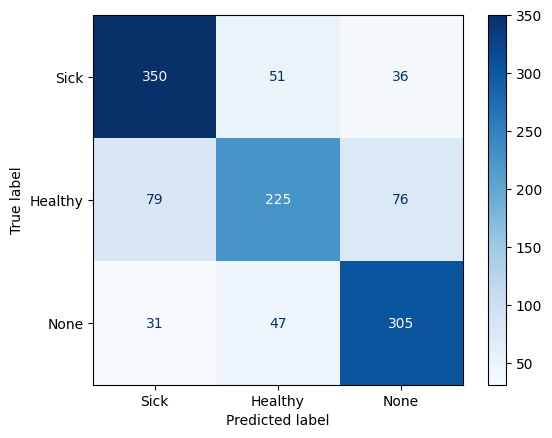

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['Sick', 'Healthy', 'None'])
disp.plot(cmap='Blues')